In [2]:
# Cell 1: Import necessary libraries
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Cell 2: Define the dataset class
class CoronaryDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get all jpg files and their corresponding labels from txt files
        self.samples = []
        for fname in os.listdir(image_dir):
            if fname.endswith(".jpg"):
                img_path = os.path.join(image_dir, fname)
                txt_path = os.path.join(image_dir, fname.replace(".jpg", ".txt"))
                # Check if the txt file exists
                if os.path.exists(txt_path):
                    try:
                        with open(txt_path, 'r') as f:
                            label = int(f.read().strip())
                        self.samples.append((img_path, label))
                    except (ValueError, FileNotFoundError):
                        print(f"Skipping {fname}: Issue with label file")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Cell 3: Set up dataset and data loaders
# Set the correct dataset path
PROCESSED_DIR = "arterydir"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CoronaryDataset(PROCESSED_DIR, transform=transform)
print(f"Total samples found: {len(dataset)}")

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Total samples found: 4238


In [5]:
# Cell 4: Set up the model
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize ResNet50 model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: RCA, LAD, LCX
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\sricharan/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.8MB/s]


In [6]:
# Cell 5: Training and validation loop
# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(10):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    print(f"[ResNet50] Epoch {epoch + 1}, Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%")
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
            
    print(f"Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%")

[ResNet50] Epoch 1, Loss: 0.4755, Accuracy: 80.88%
Validation Loss: 0.4037, Accuracy: 83.84%
[ResNet50] Epoch 2, Loss: 0.2843, Accuracy: 90.15%
Validation Loss: 0.4289, Accuracy: 85.14%
[ResNet50] Epoch 3, Loss: 0.2265, Accuracy: 91.89%
Validation Loss: 0.3186, Accuracy: 87.85%
[ResNet50] Epoch 4, Loss: 0.1784, Accuracy: 93.98%
Validation Loss: 0.2178, Accuracy: 91.63%
[ResNet50] Epoch 5, Loss: 0.1639, Accuracy: 94.60%
Validation Loss: 0.3045, Accuracy: 89.86%
[ResNet50] Epoch 6, Loss: 0.1526, Accuracy: 94.81%
Validation Loss: 0.2118, Accuracy: 92.81%
[ResNet50] Epoch 7, Loss: 0.1255, Accuracy: 95.72%
Validation Loss: 0.3188, Accuracy: 90.57%
[ResNet50] Epoch 8, Loss: 0.1032, Accuracy: 96.49%
Validation Loss: 0.2428, Accuracy: 93.51%
[ResNet50] Epoch 9, Loss: 0.1316, Accuracy: 95.69%
Validation Loss: 0.1604, Accuracy: 95.17%
[ResNet50] Epoch 10, Loss: 0.0934, Accuracy: 96.78%
Validation Loss: 0.1353, Accuracy: 96.11%


In [7]:
# Cell 6: Save the model
model_save_path = "resnet50_artery_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to resnet50_artery_model.pth


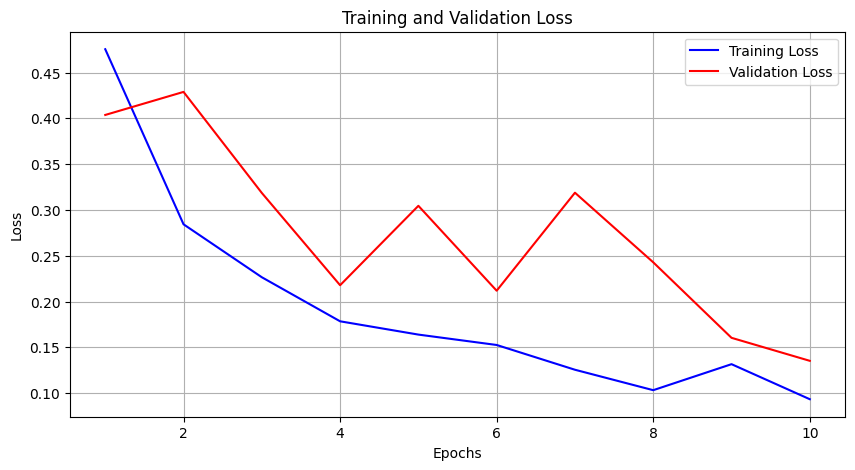

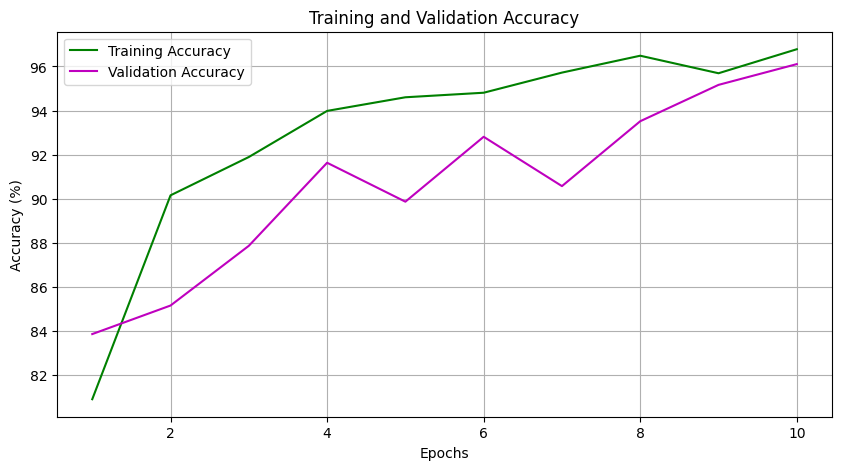

In [8]:
# Cell 7: Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_graph.png')
plt.show()

# Cell 8: Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_graph.png')
plt.show()

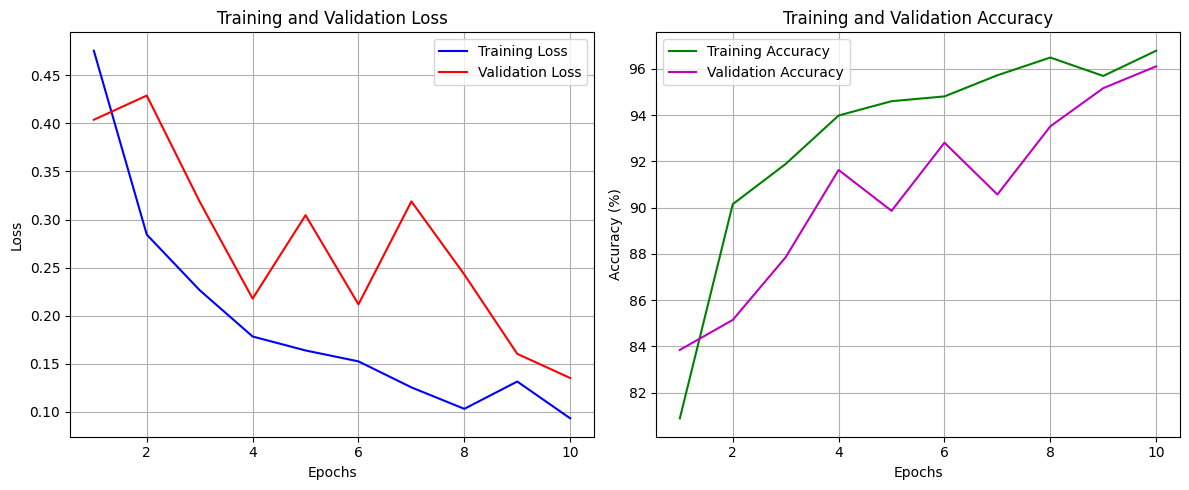

In [9]:
# Cell 9: Plot combined Train vs Validation Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('train_vs_val_graph.png')
plt.show()

In [10]:
# Cell 10: Generate confusion matrix and classification report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

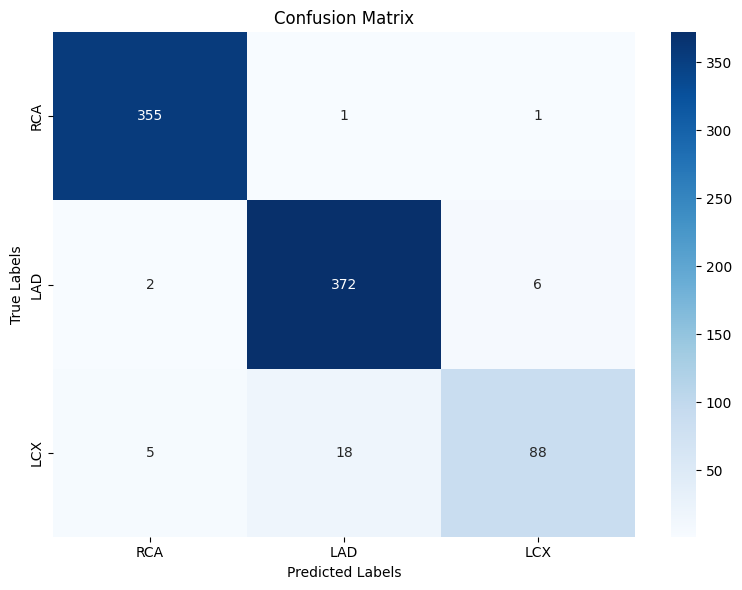


Classification Report:
              precision    recall  f1-score   support

         RCA       0.98      0.99      0.99       357
         LAD       0.95      0.98      0.96       380
         LCX       0.93      0.79      0.85       111

    accuracy                           0.96       848
   macro avg       0.95      0.92      0.94       848
weighted avg       0.96      0.96      0.96       848



In [11]:
# Cell 11: Plot Confusion Matrix
class_names = ['RCA', 'LAD', 'LCX']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Cell 12: Display Classification Report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

In [12]:
# Cell 13: Define inference function
def predict_artery(img_path, model, transform):
    # Load and preprocess the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    label_map = {0: "RCA", 1: "LAD", 2: "LCX"}
    predicted_label = label_map[predicted.item()]
    
    return predicted_label

In [13]:
# Cell 14: Test the model on a sample image
test_img_path = os.path.join(PROCESSED_DIR, "1_161.jpg")  # Update this to a specific image path that exists
if os.path.exists(test_img_path):
    prediction = predict_artery(test_img_path, model, transform)
    print(f"Predicted Artery: {prediction}")
else:
    print(f"Test image not found at {test_img_path}")
    # Find first available image for testing
    sample_images = [f for f in os.listdir(PROCESSED_DIR) if f.endswith('.jpg')]
    if sample_images:
        test_img_path = os.path.join(PROCESSED_DIR, sample_images[0])
        print(f"Using alternative image: {test_img_path}")
        prediction = predict_artery(test_img_path, model, transform)
        print(f"Predicted Artery: {prediction}")
    else:
        print("No jpg images found in the dataset directory.")

Predicted Artery: RCA
